In [1]:
!pip install yfinance ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=e03ee3fe0135577c9a870e37d4942d64ef512761f21dd188d58d1734cc0d1993
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [2]:
# Data Handling and Analysis
import pandas as pd
import numpy as np
import yfinance as yf
import ta

# Visualization
import matplotlib.pyplot as plt

# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler

# AI Model Building (TensorFlow/Keras)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Model Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
# Define the stock and the date range
stock_symbol = 'BHARTIARTL.NS'
start_date = '2010-01-01'
end_date = '2025-09-04'  # Using today's date

# Download the historical data
print(f"Downloading data for {stock_symbol}...")
df = yf.download(stock_symbol, start=start_date, end=end_date)
print("Data download complete.")

# --- Feature Engineering ---
# Use .squeeze() to ensure the data is 1-dimensional
df['SMA_20'] = ta.trend.sma_indicator(df['Close'].squeeze(), window=20)
df['EMA_20'] = ta.trend.ema_indicator(df['Close'].squeeze(), window=20)
df['RSI'] = ta.momentum.rsi(df['Close'].squeeze(), window=14)
df['BB_high'] = ta.volatility.bollinger_hband(df['Close'].squeeze(), window=20)
df['BB_low'] = ta.volatility.bollinger_lband(df['Close'].squeeze(), window=20)

# Remove rows with missing values
df.dropna(inplace=True)
df.reset_index(inplace=True)

print("\nDataset with Technical Indicators:")
print(df.head())

/tmp/ipython-input-622520968.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Data download complete.

Dataset with Technical Indicators:
Price        Date         Close          High           Low          Open  \
Ticker            BHARTIARTL.NS BHARTIARTL.NS BHARTIARTL.NS BHARTIARTL.NS   
0      2010-02-01    258.448761    260.524988    253.299714    253.299714   
1      2010-02-02    255.500595    262.186054    254.213340    261.189462   
2      2010-02-03    256.621674    259.736000    254.545446    257.452153   
3      2010-02-04    252.552307    256.621720    249.562557    254.960732   
4      2010-02-05    249.188828    252.843001    244.496555    250.808280   

Price         Volume      SMA_20      EMA_20        RSI     BB_high  \
Ticker BHARTIARTL.NS                                                  
0            4288766  267.594607  266.300623  40.225170  278.541353   
1            5096874  266.865851  265.272049  37.707820  278.937668   
2            4049198  265.979298  264.448204  39.264352  278.322833   
3            2861509  265.034615  263.315261 

In [4]:
# 1. Define the features and the target
# We'll use the Close price and our new indicators as features
features = ['Close', 'SMA_20', 'EMA_20', 'RSI', 'BB_high', 'BB_low']
target_col = 'Close'

# Create a new DataFrame with only the features we need
data = df[features]

# 2. Scale the data to be between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 3. Create sequences
# The model will look at the past 60 days of data to predict the next day
sequence_length = 60
X, y = [], []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])  # Features for the past 60 days
    y.append(scaled_data[i, features.index(target_col)]) # The 'Close' price on the next day

X, y = np.array(X), np.array(y)

# 4. Split data into training and testing sets (80% train, 20% test)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (3032, 60, 6)
X_test shape: (758, 60, 6)
y_train shape: (3032,)
y_test shape: (758,)


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model architecture
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

# Get a summary of the model's structure
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,901 (128.52 KB)

 Trainable params: 32,901 (128.52 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
print("Training the model... This may take a few minutes.")
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_split=0.1, # Use 10% of training data for validation
    verbose=1
)
print("Model training complete.")

Training the model... This may take a few minutes.
Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 0.0016 - val_loss: 6.3584e-04
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 1.8362e-04 - val_loss: 1.1214e-04
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 1.3510e-04 - val_loss: 1.0901e-04
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 1.2168e-04 - val_loss: 2.9084e-04
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 8.8305e-05 - val_loss: 3.3081e-04
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 7.9785e-05 - val_loss: 4.4318e-04
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 7.7716e-05 - val_loss: 4.1135e-04
Epoch 8/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 7.7982e-05 - val_loss: 8.6637e-05
Epoch 9/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 6.9390e-05 - val_loss: 9.6144e-05
Epoch 10/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 6.6668e-05 - val_loss: 9.0538e-05
Epoch 11/50
86/86 ━━━━

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


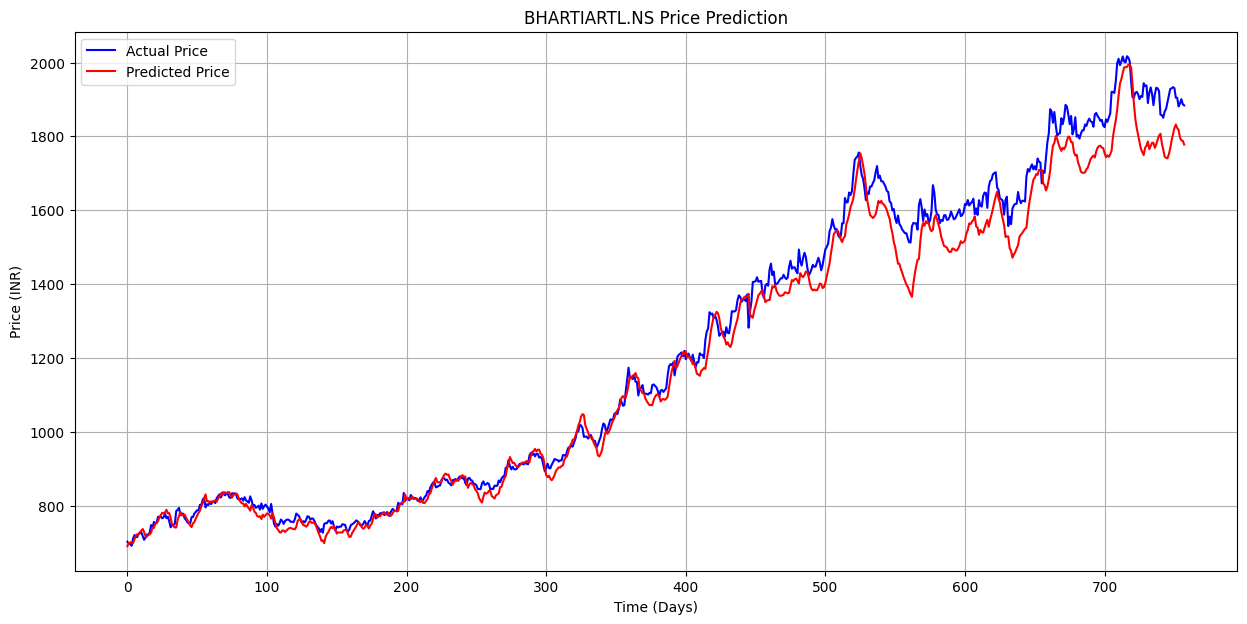


Model Evaluation Metrics:
Root Mean Squared Error (RMSE): 56.71 INR
Mean Absolute Error (MAE): 40.01 INR
R-squared (R²) Score: 0.9812


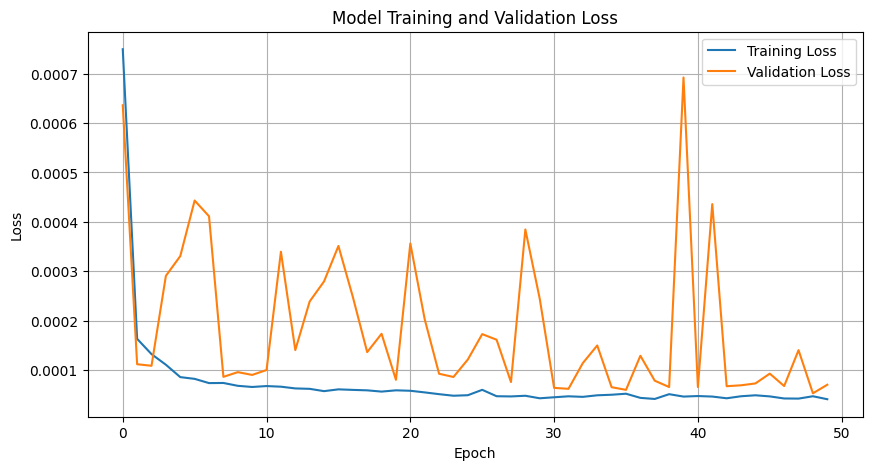

In [7]:
# 1. Make predictions on the test data
predictions_scaled = model.predict(X_test)

# 2. Inverse transform the predictions to get actual price values
# We need to create a dummy array with the same number of features as the scaler
dummy_array = np.zeros((len(predictions_scaled), len(features)))
dummy_array[:, features.index(target_col)] = predictions_scaled.flatten()
predicted_prices = scaler.inverse_transform(dummy_array)[:, features.index(target_col)]

# We also need to inverse transform the actual test values (y_test)
dummy_array = np.zeros((len(y_test), len(features)))
dummy_array[:, features.index(target_col)] = y_test.flatten()
actual_prices = scaler.inverse_transform(dummy_array)[:, features.index(target_col)]

# 3. Visualize the results
plt.figure(figsize=(15, 7))
plt.plot(actual_prices, color='blue', label='Actual Price')
plt.plot(predicted_prices, color='red', label='Predicted Price')
plt.title(f'{stock_symbol} Price Prediction')
plt.xlabel('Time (Days)')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.show()

# 4. Calculate error metrics
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mae = mean_absolute_error(actual_prices, predicted_prices)
r2 = r2_score(actual_prices, predicted_prices)

print("\nModel Evaluation Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} INR")
print(f"Mean Absolute Error (MAE): {mae:.2f} INR")
print(f"R-squared (R²) Score: {r2:.4f}")

# 5. Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# First, ensure your Google Drive is connected
from google.colab import drive
drive.mount('/content/drive')

# Define the file path where you want to save the model
model_save_path = '/content/drive/MyDrive/my_lstm_model.h5'

# Save the entire model to that path
model.save(model_save_path)

print(f"Model successfully saved to: {model_save_path}")

Mounted at /content/drive
Model successfully saved to: /content/drive/MyDrive/my_lstm_model.h5
